# Gaussian process simulation

In [260]:
import numpy as np
import scipy as sp
import scipy.stats as spstats
import scipy.optimize as spopt
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel

import sys

if not '../code' in sys.path:
    sys.path.append('../code')

import bayes_opt as bo
import info_architecture as ia
import plotting
import utils
import kernels
import gaussian_process as gp

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
def f(x, sigma=0):
    return ((x / 8) + np.sin((x ** 2) / 6) + np.cos(x - 4) / 4) + np.random.randn(*x.shape) * sigma

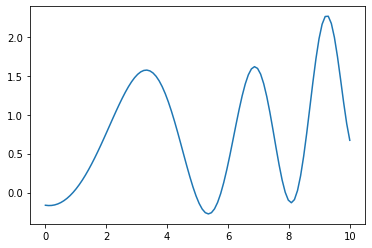

In [129]:
bounds = np.array([[0., 10.]])
xs = np.linspace(bounds[0, 0], bounds[0, 1], 100).reshape(-1, 1)
plt.plot(xs, f(xs));

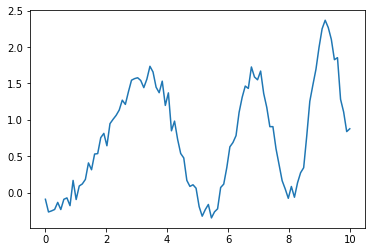

In [130]:
plt.plot(xs, f(xs, sigma=.1));

In [131]:
sigma = .2
X_init = np.array([[2], [6]])
Y_init = f(X_init, sigma=sigma)

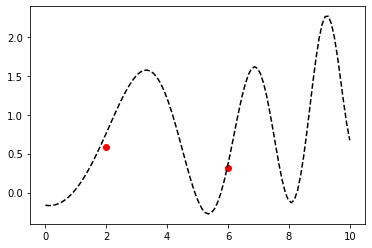

In [132]:
plt.plot(xs, f(xs), linestyle='--', color='k')
plt.scatter(X_init, Y_init, color='r')

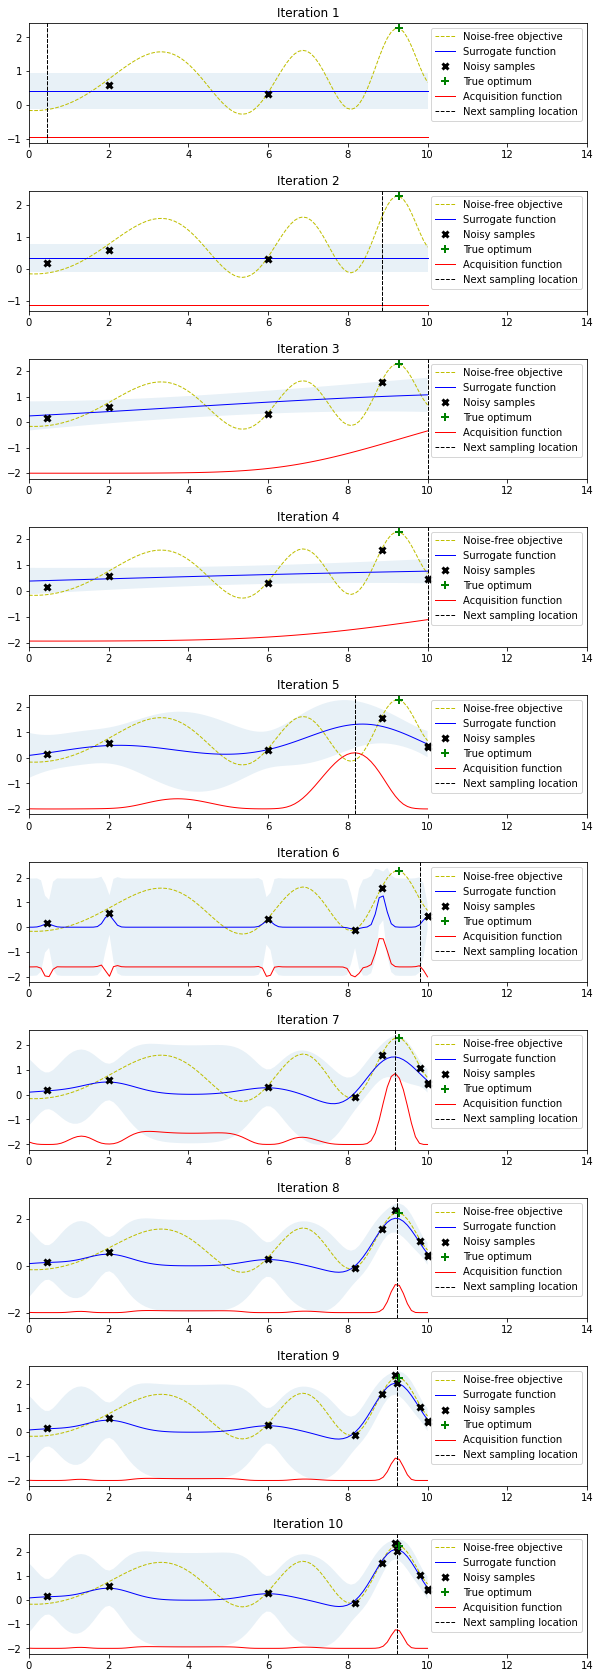

In [148]:
rbf = RBF(length_scale=1.)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=(sigma * 2)**2)

n_iter = 10
plt.figure(figsize=(22, n_iter * 3))
plt.subplots_adjust(hspace=.4)

y_true = f(xs, sigma=0)
X_samp, Y_samp = X_init, Y_init

for i in range(n_iter):
    gpr.fit(X_samp, Y_samp)
    X_next = bo.propose_next(bo.expected_improvement,
                             X_samp,
                             Y_samp,
                             gpr,
                             bounds)
    Y_next = f(X_next, sigma=sigma)
    
    plt.subplot(n_iter, 2, 2 * i + 1)
    plotting.plot_approximation(gpr, xs, y_true, X_samp, Y_samp, X_next)
#     plt.subplot(n_iter, 2, 2 * i + 2)
    plotting.plot_acquisition(xs, 10 * bo.expected_improvement(xs, X_samp, Y_samp, gpr) - 2, X_next)
    plt.title(f"Iteration {i + 1}")
    plt.xlim(0, xs.max() + 4)
    plt.legend()
    
    X_samp = np.vstack((X_samp, X_next))
    Y_samp = np.vstack((Y_samp, Y_next))
plt.show()

## Bayesian optimization of Information Architectures

Algorithm

1. Initial random dashboard
2. Query function (get accuracy on 3 [4? 5?] judgments)
3. Compute expected improvment (UCB?)
4. Present next dashboard and repeat

How to simulate 3

1. Randomly (assign 1, 2, or 3 correct responses)
2. Specify a score *a priori* for each dashboard
3. Specify a score *a priori* for each dashboard group and draw from that
4. Some combination of 1-3

Design choices

* $\sigma$
* Acquisition function
    * EI
    * UCB
    * LCB
* Covariance function
    * RBF
    * Matern
* Random restarts

### Setup

In [268]:
# 1. Generate a small number of possible dashboards (20)
# Defined by lists of (row1, col1, height, width) tuples
arr1 = [
    (0, 0, 12, 2),
    (0, 2, 4, 10),
    (4, 2, 6, 10),
    (10, 2, 2, 10)
]
arr2 = [
    (0, 0, 2, 5),
    (0, 5, 2, 5),
    (0, 10, 12, 2),
    (2, 0, 6, 5),
    (2, 5, 6, 5),
    (8, 0, 4, 10),
    (0, 10, 12, 2)
]
arr3 = [
    (0, 0, 12, 3),
    (0, 3, 2, 6),
    (2, 3, 8, 6),
    (8, 3, 4, 6),
    (0, 9, 12, 3)
]
arr4 = [
    (0, 0, 7, 12),
    (7, 0, 5, 4),
    (7, 4, 5, 4),
    (7, 8, 5, 4)
]
arr5 = [
    (0, 0, 9, 10),
    (8, 0, 3, 12),
    (0, 10, 3, 2),
    (3, 10, 3, 2),
    (6, 10, 3, 2)
]

n_components = 8
components = np.arange(n_components) + 1
def spec2arr(spec, height=12, width=12, n_components=n_components):
    components = np.random.choice(n_components, size=len(spec), replace=False) + 1
    arr = np.zeros((height, width))
    spec = np.random.permutation(spec)
    for i, comp in zip(range(spec.shape[0]), components):
        r1, c1, h, w = spec[i]
        arr[r1:r1 + h, c1:c1 + w] = comp
    return arr

treemaps = []
info_archs = []
failures = []
feat_vecs = []
for i, arch in enumerate([arr1, arr2, arr3, arr4, arr5]):
    for j in range(4):
        arr = spec2arr(arch)
        treemaps.append(arr)
        try:
            info_arch = ia.InfoArchTree.from_array(i * 4 + j, arr)
            info_archs.append(info_arch)
            feat_vecs.append(info_arch.get_feature_vector(components))
        except Exception as e:
            print(e)
            failures.append(i * 4 + j)
            pass
print(f'Failures: {failures}')

Failures: []


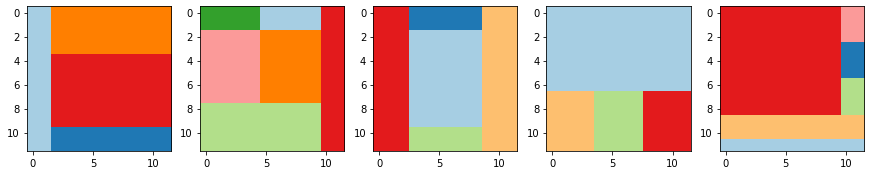

In [269]:
fig, axs = plt.subplots(1, 5, figsize=(5 * 3, 1 * 3))
for treemap, ax in zip(treemaps[::4], axs.flat):
    plotting.plot_treemap(treemap, ax=ax)

In [188]:
# 2. Compute the distances between them
distance_matrix = utils.compute_distances(info_archs)

100%|██████████| 400/400 [00:07<00:00, 50.67it/s]


### Initializing task

In [194]:
idx_init = np.random.choice(len(info_archs))
print(idx_init)

15


In [273]:
sigma = .5
length_scale = 1.
kernel = RBF(length_scale=length_scale)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma ** 2)

### Defining simulation

In [241]:
n_per_db = 6
accuracy = lambda x: x / n_per_db

def simulate_response_random(*args, **kwargs):
    return accuracy(np.random.binomial(n_per_db, .8))

In [283]:
idx_obs = [idx_init]
X_init = np.array([feat_vecs[idx_init]])
Y_init = np.array([[simulate_response_random()]])

In [284]:
gpr.fit(X_obs, Y_obs)

GaussianProcessRegressor(alpha=0.25, copy_X_train=True,
                         kernel=RBF(length_scale=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [289]:
Y_init

array([[1.]])

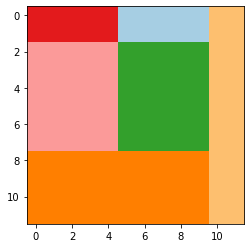

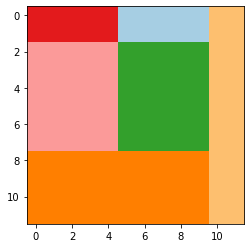

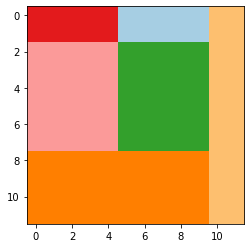

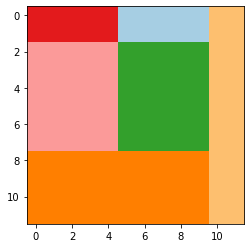

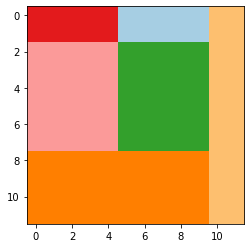

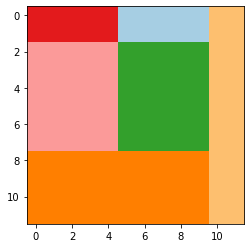

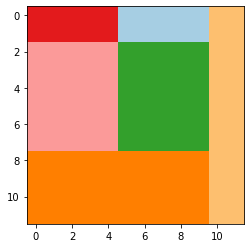

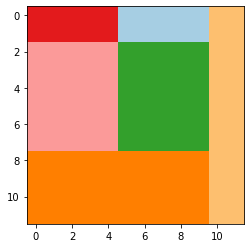

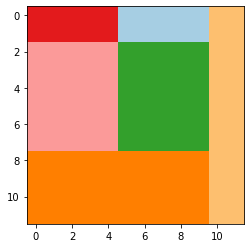

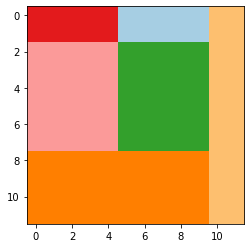

In [288]:
n_iter = 10

X_samp, Y_samp = X_init, Y_init

for i in range(n_iter):
    gpr.fit(X_samp, Y_samp)
    exp_imp = bo.expected_improvement(feat_vecs, X_obs, Y_obs, gpr)
    idx_next = np.argmin(exp_imp)
    X_next = feat_vecs[idx_next]
    Y_next = np.array([[simulate_response_random()]])
    
    plotting.plot_treemap(treemaps[idx_next])
    plt.show()
    
    X_samp = np.vstack((X_samp, X_next))
    Y_samp = np.vstack((Y_samp, Y_next))